# **Final Project Code**

### **Import Packages and Data** 

In [259]:
#Import Packages
import time

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

sns.set_style('whitegrid')

In [194]:
# User-defined GridSearchCV results function
def gscv_results(gscv_object, main_scorer, *add_scores):
    '''Take an sklearn GridSearchCV object and return best model parameters and a 
    pandas dataframe of the main score and specified scorers for the best model.
    
    gscv_object: fitted GridSearchCV object with one or multiple scorers.
    main_scorer: scorer passed to gscv_object, or refit score if gscv_object has multiple scorers.
    add_scores: list of additional score names passed to gscv_object.'''
    cv_results = pd.DataFrame(gscv_object.cv_results_).sort_values(by=f'mean_test_{main_scorer}', ascending=False)

    best_params = gscv_object.best_params_
    best_index = gscv_object.best_index_

    # create data frame with best main score
    best_score = gscv_object.best_score_.round(4)
    results = pd.DataFrame(data={f'{main_scorer}':[best_score]})
    
    # for score in additional scores, add column with score
    for score in add_scores:
        results[f'{score}'] = cv_results.loc[best_index, f'mean_test_{score}'].round(4)

    return best_params, results

In [195]:
# User-defined cross_validate results function
def cv_results(cv_object, main_scorer, *add_scores):
    '''Take a sklearn cross_validate object and return a pandas dataframe of 
    the average main score and average of any additional scores across cross 
    validated trials.
    
    cv_object: fitted cross_validate object with one or multiple scorers.
    main_scorer: scorer passed to cross_validate object, or refit score if cross_validate
                 has multiple scorers.
    add_scores: list of additional score names passed to cv_object.'''
     # create data frame with best main score
    main_scorer_avg = cv_object[f'test_{main_scorer}'].mean()
    results = pd.DataFrame(data={f'{main_scorer}': [main_scorer_avg]})
    
    # for score in additional scores, calculate average and add column with score
    for score in add_scores:
        score_avg = cv_object[f'test_{score}'].mean()
        results[f'{score}'] = score_avg
    
    return results

In [3]:
# Read in dataframes
try:
    contract_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/phone.csv', parse_dates=True)
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv', parse_dates=True)

In [4]:
# Print df info
print('Contract DF')
print()
print(contract_df.info())
print()

contract_df.head()

Contract DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
print('Internet DF')
print()
print(internet_df.info())
print()

internet_df.head()

Internet DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
print('Personal DF')
print() 
print(personal_df.info())
print()

personal_df.head()

Personal DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
print('Phone DF')
print()
print(phone_df.info())
print()

phone_df.head()

Phone DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### **Prepare Data**

#### Convert Column Names to Snake Case

In [8]:
# Convert column names to snake case
contract_df.columns = (contract_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

internet_df.columns = (internet_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

personal_df.columns = (personal_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

phone_df.columns = (phone_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for columnn in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_i_d
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_i_d
internet_service
online_security
online_backup
device_protection
tech_support
streaming_t_v
streaming_movies

Personal Columns:
streaming_movies
streaming_movies
streaming_movies
streaming_movies
streaming_movies

Phone Columns:
customer_i_d
multiple_lines


* All column names look good except 'customer_i_d' and 'steraming_t_v'.
* Fix these two column names below.

In [9]:
# Fix Customer ID and Streaming TV column names
contract_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
internet_df.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'}, 
                   errors='raise', inplace=True)
personal_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
phone_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for column in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_id
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies

Personal Columns:
customer_id
gender
senior_citizen
partner
dependents

Phone Columns:
customer_id
multiple_lines


* All column names are successfully converted to snake case.

#### Check for Implicit Missing Values

We already know there are no np.nan missing values in the dataframes. Frequency tables of each variable are displayed to determine whether missing values have been marked with other words or symbols.

##### Contract DF Missing

In [10]:
# Categorical columns
categorical_columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method']

for column in categorical_columns:
    display(contract_df[column].value_counts().reset_index())
    print()

,begin_date,count
0,2014-02-01,366
1,2019-10-01,237
2,2019-11-01,237
3,2019-09-01,237
4,2020-01-01,233
5,2019-12-01,220
6,2014-03-01,178
7,2019-07-01,156
8,2019-08-01,146
9,2019-06-01,141


,end_date,count
0,No,5174
1,2019-11-01 00:00:00,485
2,2019-12-01 00:00:00,466
3,2020-01-01 00:00:00,460
4,2019-10-01 00:00:00,458


,type,count
0,Month-to-month,3875
1,Two year,1695
2,One year,1473


,paperless_billing,count
0,Yes,4171
1,No,2872


,payment_method,count
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


* There are no implicit missing values in the contract df categorical columns.

In [11]:
# Numeric Columns
numeric_columns = ['monthly_charges', 'total_charges']

for column in numeric_columns:
    print(column)
    display(contract_df[column].value_counts().reset_index().sort_values(by=column, ascending=False).reset_index(drop=True))
    print()

monthly_charges


,monthly_charges,count
0,118.75,1
1,118.65,1
2,118.60,2
3,118.35,1
4,118.20,1
...,...,...
1580,18.75,1
1581,18.70,2
1582,18.55,1
1583,18.40,1



total_charges


,total_charges,count
0,999.9,1
1,999.8,1
2,999.45,1
3,998.1,1
4,997.75,1
...,...,...
6526,100.4,1
6527,100.35,1
6528,100.25,1
6529,100.2,1


* Total charges does have an implicit missing value marked as an empty space in the dataframe.

Fill missing value in total charges with np.nan

In [12]:
contract_df['total_charges'] = contract_df['total_charges'].replace(' ', np.nan)

display(contract_df['total_charges'].value_counts().reset_index().sort_values(by='total_charges').reset_index(drop=True))

,total_charges,count
0,100.2,1
1,100.25,1
2,100.35,1
3,100.4,1
4,100.8,1
...,...,...
6525,997.75,1
6526,998.1,1
6527,999.45,1
6528,999.8,1


In [13]:
# Check spaces have been filled with np.nan
print('Total Charges Missing:')
display(contract_df['total_charges'].isna().sum())

Total Charges Missing:


11

* Missing values have been replaced with np.nan. The number of missing values is equal to the number of spaces in the original variable.
* This is such a small number of missing values, these observations will be dropped from the analysis.

##### Internet DF Missing

In [14]:
# Check for implicit missing values
categorical_columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
                       'tech_support', 'streaming_tv', 'streaming_movies']

for column in categorical_columns:
    display(internet_df[column].value_counts().reset_index())
    print()

,internet_service,count
0,Fiber optic,3096
1,DSL,2421


,online_security,count
0,No,3498
1,Yes,2019


,online_backup,count
0,No,3088
1,Yes,2429


,device_protection,count
0,No,3095
1,Yes,2422


,tech_support,count
0,No,3473
1,Yes,2044


,streaming_tv,count
0,No,2810
1,Yes,2707


,streaming_movies,count
0,No,2785
1,Yes,2732


* There are no implicit missing values in the internet dataframe.

##### Personal DF Missing

In [15]:
# Check for implicit missing values
categorical_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

for column in categorical_columns:
    display(personal_df[column].value_counts().reset_index())

,gender,count
0,Male,3555
1,Female,3488


,senior_citizen,count
0,0,5901
1,1,1142


,partner,count
0,No,3641
1,Yes,3402


,dependents,count
0,No,4933
1,Yes,2110


* There are  no implicit missing values in the personal dataframe.

##### Phone DF Missing

In [16]:
# Check for implicit duplicates
display(phone_df['multiple_lines'].value_counts().reset_index())

,multiple_lines,count
0,No,3390
1,Yes,2971


* There are no implicit missing values in the phone dataframe.  

* All columns in all datasets have been explored for implicit missing values. 'Total_charges' is the only column with an implicit missing value; there are no implicit missing values in any other column.

#### Duplicates

##### Check for full duplicates

In [17]:
print('Contract DF Duplicates:')
print(contract_df.duplicated().sum())
print()

print('Internet DF Duplicates:')
print(internet_df.duplicated().sum())
print()

print('Personal DF Duplicates:')
print(personal_df.duplicated().sum())
print()

print('Phone DF Duplicates:')
print(phone_df.duplicated().sum())

Contract DF Duplicates:
0

Internet DF Duplicates:
0

Personal DF Duplicates:
0

Phone DF Duplicates:
0


* There are no full duplicates in any dataframe.

##### Check for implicit duplicate of customer ids

In [18]:
print('Contract DF Customer ID Duplicates:')
print(contract_df['customer_id'].duplicated().sum())
print()

print('Internet DF Customer ID Duplicates:')
print(internet_df['customer_id'].duplicated().sum())
print()

print('Personal DF Customer ID Duplicates:')
print(personal_df['customer_id'].duplicated().sum())
print()

print('Phone DF Customer ID Duplicates:')
print(phone_df['customer_id'].duplicated().sum())

Contract DF Customer ID Duplicates:
0

Internet DF Customer ID Duplicates:
0

Personal DF Customer ID Duplicates:
0

Phone DF Customer ID Duplicates:
0


* There are no duplicate customer IDs in any dataframe.
* I do not have concerns about duplication in this dataset.

#### Fix Data Types

The contract dataframe is the only dataframe with incorrect data types. 

##### Change begin date to datetime and total charges to float

In [19]:
print('Contract DF Original Data Types:')
print(contract_df.info())
contract_df.head()

Contract DF Original Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [20]:
# Change begin_date to datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], yearfirst=True)

# Change total_charges to float
contract_df['total_charges'] = contract_df['total_charges'].astype('float')

print(contract_df.info())
contract_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


* Begin date is changed to datetime. 
* Total charges is changed to float.

#### Merge Data Frames

In [23]:
merged_df = contract_df.merge(personal_df, how='outer')
merged_df = merged_df.merge(internet_df, how='outer')
merged_df = merged_df.merge(phone_df, how='outer')

print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


* All dataframes have been outer-merged, and new np.nan values have been created where customers do not belong to internet or phone plans.

#### Fill Missing Values from Outer Merge

Missing values from the outer merge will be filled with 'no_plan', representing customers who do not have either a phone or internet plan.

In [24]:
# Fill missing values with 'no_plan'
merged_df.iloc[: , 12:20] = merged_df.iloc[:, 12:20].fillna('no_plan')

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

* All missing values have been filled with 'no_plan'

#### Create New Features

##### Churn Feature
0 = did not churn, 1 = did churn

In [25]:
merged_df['churned'] = np.where(merged_df['end_date'] == 'No', 0, 1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


##### Begin Year Feature
Year of plan start date

In [26]:
merged_df['begin_year'] = merged_df['begin_date'].dt.year

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019


##### Total Internet Services Feature
Sum of Internet Service Subscriptions

In [27]:
def services_sum(row):
    '''Counts the number of internet services a customer subscribes
    to and returns the total number of services.'''
    internet_services = 0
    
    security = row['online_security'] 
    backup = row['online_backup'] 
    protection = row['device_protection']
    support = row['tech_support']
    tv = row['streaming_tv']
    movies = row['streaming_movies']
    
    services = [security, backup, protection, support, tv, movies]
    
    for service in services:
        if service == 'Yes':
            internet_services += 1
            
    return internet_services

merged_df['total_internet_services'] = merged_df.apply(services_sum, axis=1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0


##### Contract Length Feature
Days from begin date to end_date, or if no end date, days from begin date to date of last update

In [176]:
# Create intermediate column with 'No' end date filled with last data update '2020-02-01'
merged_df['end_date_or_last_date'] = np.where(merged_df['end_date'] == 'No', '2020-02-01', merged_df['end_date'])

# Convert to date time
merged_df['end_date_or_last_date'] = pd.to_datetime(merged_df['end_date_or_last_date'], yearfirst=True, format='mixed')

# Create column with days between begin date and end date or 2020-02-01
merged_df['contract_length'] = (merged_df['end_date_or_last_date'] - merged_df['begin_date']).dt.days

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0,2019-11-01,61


* Four new columns have been created, with churn, begin year, total internet services, and contract length (days).

### Prepare Data Conclusions
* Missing values have been explored and cleaned from the dataset. The implicit missing value in total charges of ' ' has been replaced with np.nan. There were no other missing values found.
* No duplicates were found in the four datasets.
* The four datasets have been outer-merged together. Missing values were filled with 'no_plan' to represent customers who do not have either a phone or internet service.
* Four new features were created:  
    - **churn**: 0 = did not churn, 1 = did churn
    - **begin_year**: Year of contract start date
    - **total_internet_services**: Number of internet services a customer subscribes to
    - **contract_length**: Days between plan begin date and plan end date, or if a customer has not churned, days between plan begin date and last data update (2020-01-01)

## **Exploratory Analysis**

##### Merged Dataframe with Updated Features

In [178]:
merged_df.info()

Merged Dataframe with Added Features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 7043 non-null   object        
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   object        
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7032 non-null   float64       
 8   gender                   7043 non-null   object        
 9   senior_citizen           7043 non-null   int64         
 10  partner                  7043 non-null   object        
 11  dependents               7043 non-null   object        


In [179]:
display(merged_df.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0,2019-11-01,61


##### Bar Plot of Target - Churn

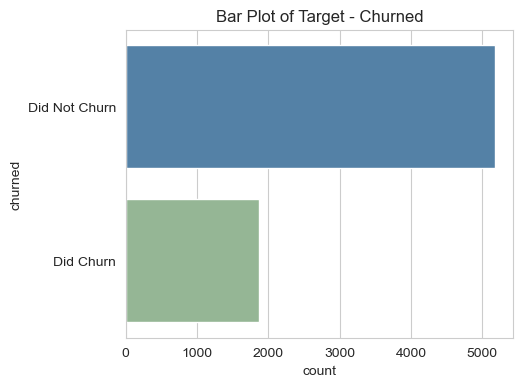

In [ ]:
plt.figure(figsize=(5, 4))

sns.countplot(merged_df, y='churned', palette=['steelblue', 'darkseagreen'])

plt.title('Bar Plot of Target - Churned')
plt.yticks(ticks=[0, 1], labels=['Did Not Churn', 'Did Churn'])

plt.show()

* Almost 3 times as many customers did not churn than those who did churn.
* This is an imbalanced classification problem.

##### Bar Plots of Categorical Features by Churn

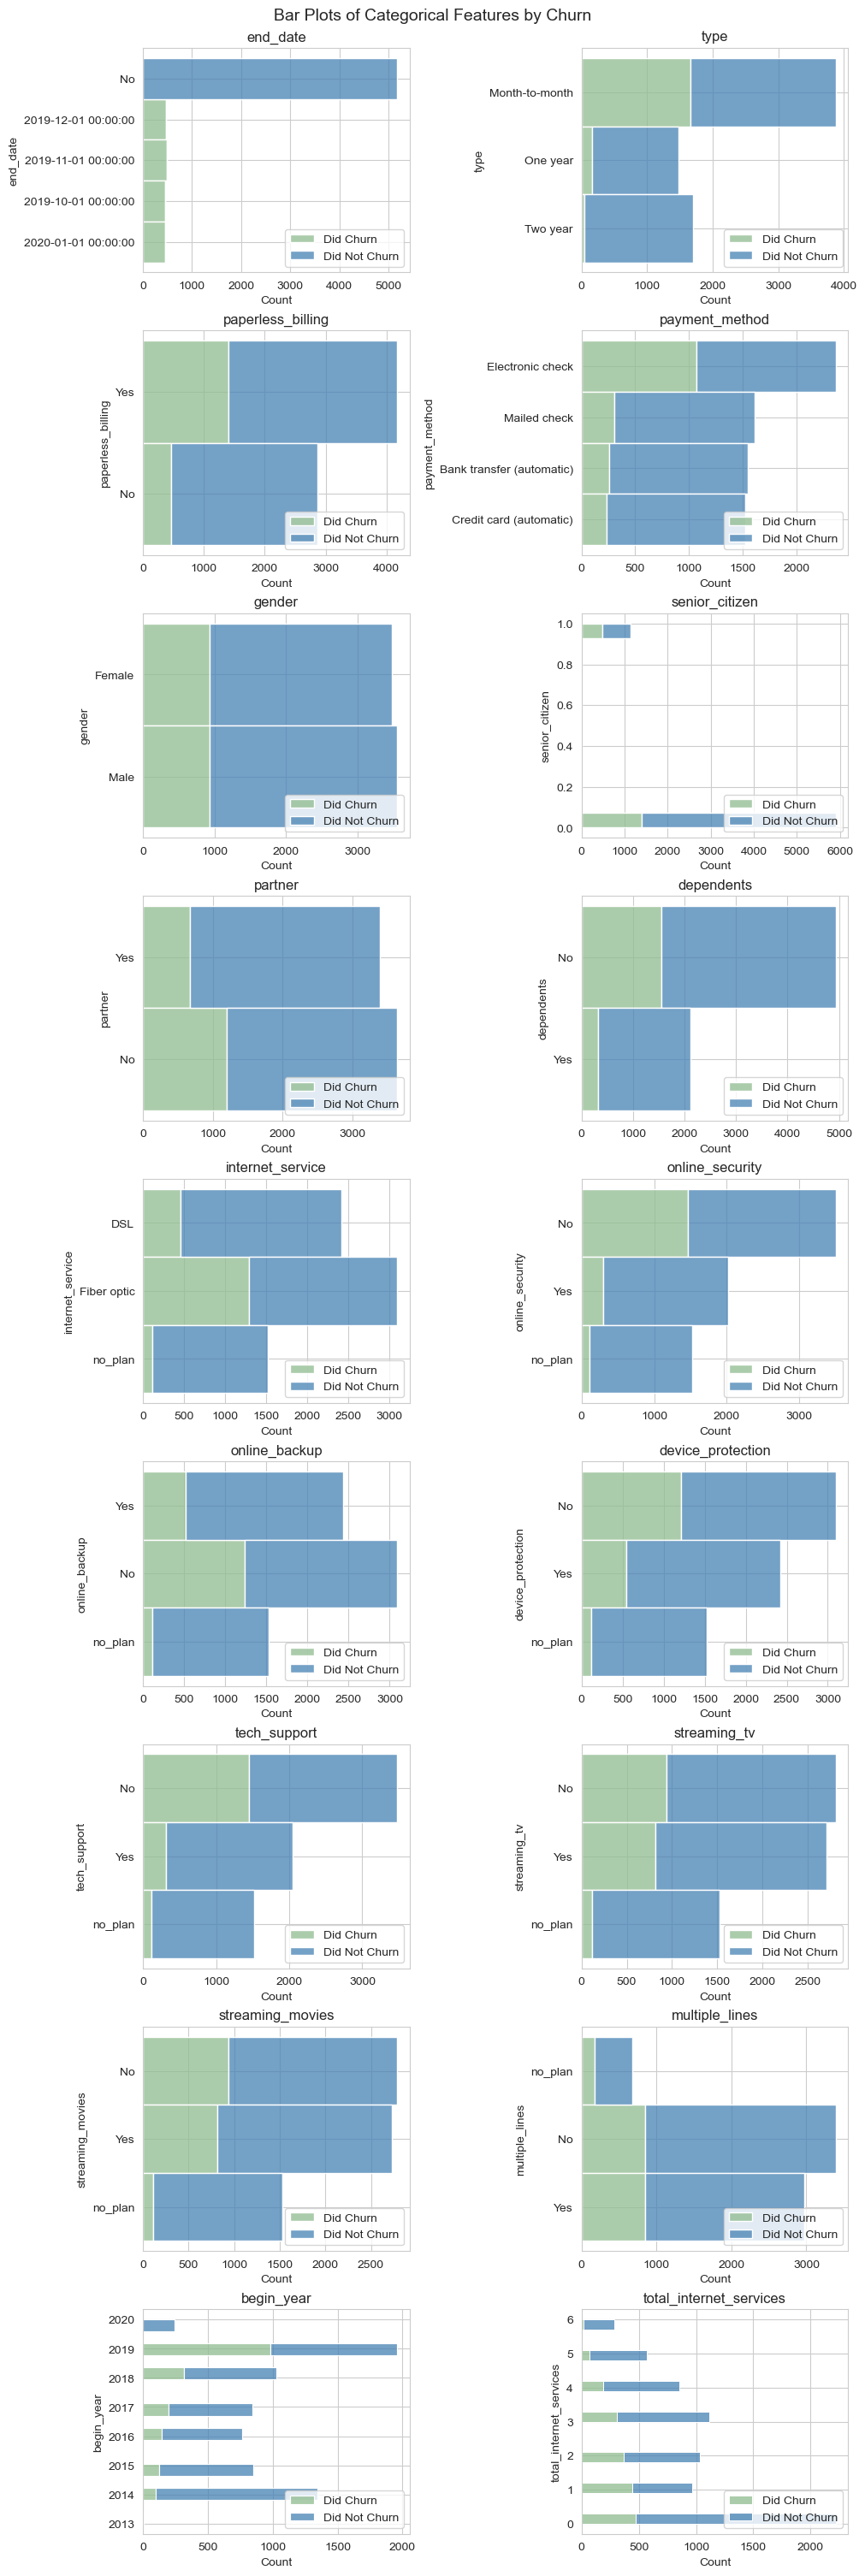

In [130]:
categorical_columns = merged_df.drop(['customer_id', 'begin_date', 'monthly_charges', 'total_charges', 
                                      'contract_length', 'end_date_or_last_date'], axis=1)

fig, axs = plt.subplots(9, 2, figsize=(10, 30), layout='constrained')
fig.suptitle("Bar Plots of Categorical Features by Churn", fontsize=14)

for column, ax in zip(categorical_columns.columns.drop('churned'), axs.ravel()):
    count_plot = sns.histplot(merged_df, y=column, hue='churned', 
                              palette=['steelblue', 'darkseagreen'], ax=ax,
                              multiple='stack')
    ax.set_title(f'{column}')
    ax.legend(['Did Churn', 'Did Not Churn'], loc='lower right')  
    
plt.show()

* This dataset contains customers who churned during the months of October, November, and December 2019 and January 2020.
* Most customers are month-to-month. Month-to-month customers are more likely to churn than customers with other plan types.
* Electronic Check is the most popular payment method. Customers who pay with electronic checks are more likely to churn than customers who pay with other methods.
* There are an almost equal number of males and females. The two genders are equally likely to churn.
* Most customers are not senior citizens.
* Customers who do not have extra internet services are generally more likely to churn than customers who do. Customers with 6 additional internet services are the least likely to churn.
* 2014 and 2019 are the most common plan start years. The earlier a customer joined the company, the less likely it is that they have churned.

##### Time Series of Customer Churn by Plan Start Date

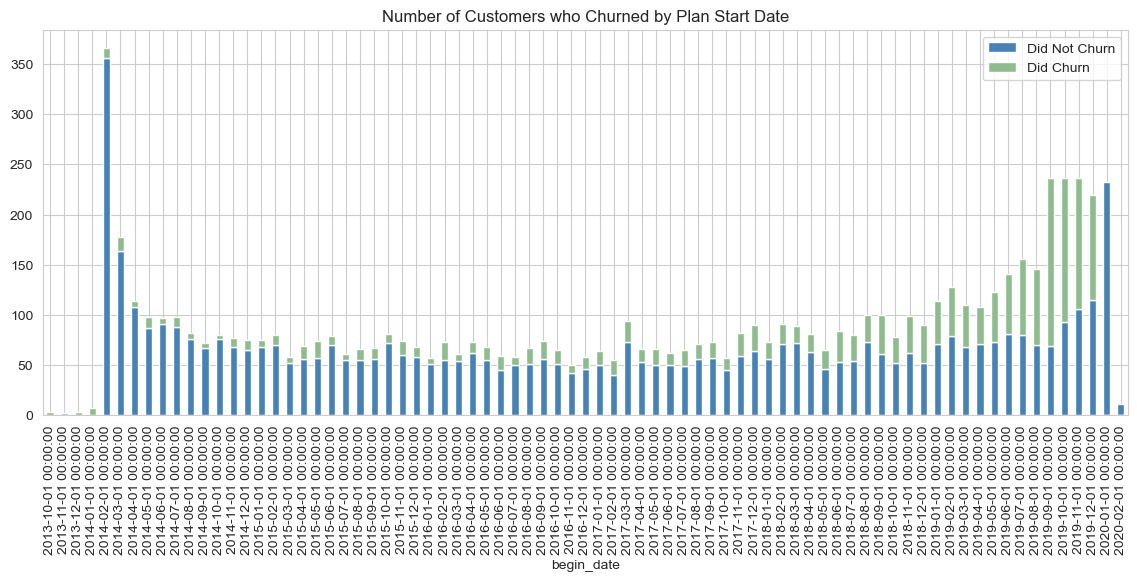

In [65]:
churned_by_date = merged_df.groupby(['begin_date', 'churned']).size().reset_index().pivot(columns='churned', index='begin_date', values=0)

churned_by_date.plot(kind='bar', stacked=True, figsize=(14, 5), color=['steelblue', 'darkseagreen'])

plt.title('Number of Customers who Churned by Plan Start Date')
plt.legend(['Did Not Churn', 'Did Churn'])

plt.show()

* Customers who began their contracts in 2014 - 2018 are almost all still with the company.
* About 50% of customers who began their contracts in 2019 - 2020 have already churned.
* New customers are more likely to leave than old customers.

##### Histograms of Continuous Features

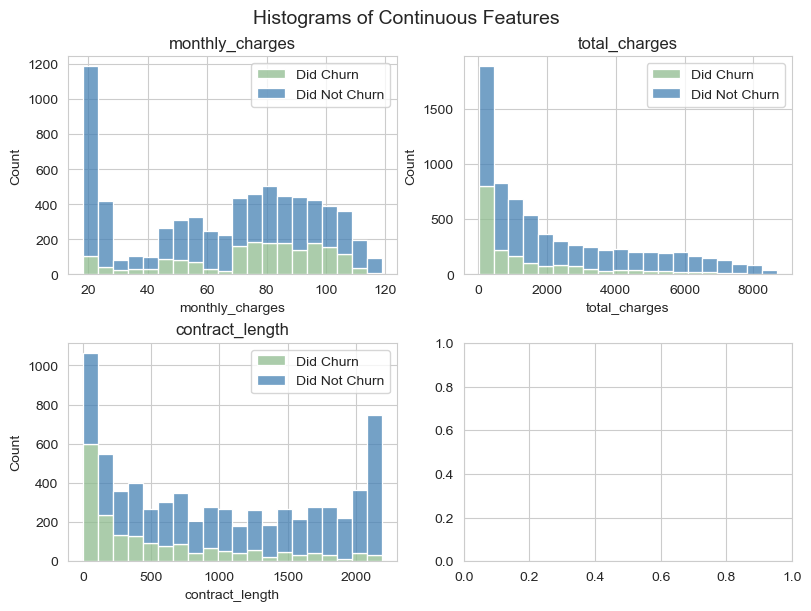

In [168]:
continuous_columns = merged_df[['monthly_charges', 'total_charges', 'contract_length']]

fig, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')
fig.suptitle('Histograms of Continuous Features', fontsize=14)

for column, ax in zip(continuous_columns, axs.ravel()):
    sns.histplot(merged_df, x=column, palette=['steelblue', 'darkseagreen'], 
                 bins=20, hue='churned', ax=ax, multiple='stack')
    ax.set_title(f'{column}')
    ax.legend(labels=['Did Churn', 'Did Not Churn']) 
    
plt.show()

* The distribution of monthly charges has three peaks at $20, $50, and $80 per month.
* Total charges is highly right skewed, with most people paying close to $0 total and only a few people paying over $6000 over the life of their plan.
* Contract length is bi-modal, with many people having contracts less than 100 months or more than 2000 months.

#### Correlations of Numeric Features

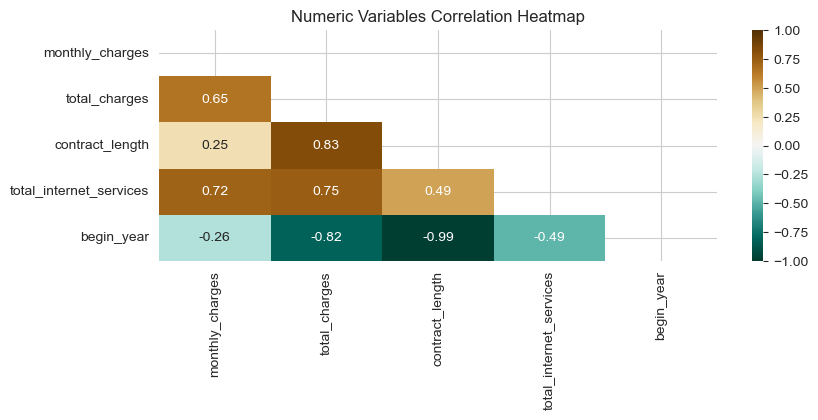

In [156]:
corr_matrix = merged_df[['monthly_charges', 'total_charges', 'contract_length', 
                         'total_internet_services', 'begin_year']].corr()
ones_triangle = np.triu(np.ones_like(corr_matrix))

plt.figure(figsize=(9, 3))
heatmap = sns.heatmap(corr_matrix, mask=ones_triangle, vmin=-1, vmax=1,
                      annot=True, cmap='BrBG_r')
heatmap.set_title('Numeric Variables Correlation Heatmap')

plt.show()

* The correlation heatmap shows high correlations between numeric features, representing multicollinearity, and a violation of the assumption of non-multicollinearity. Some features will need to be removed from the model.
* Since total charges is highly correlated with total internet services (r = 0.72), contract length (r = 0.83), monthly charges (r = 0.65), and begin year (r = -0.99), total charges will be dropped from the model.
* Total internet services is highly correlated with monthly charges (r = 0.72) and contract length (r = 0.49) and will also be dropped from the model.
* Begin year and contract length have a very strong, negative relationship (r = -0.99). Because contract length was calculated based on an artificial end date for customers who still have contracts, begin year is a more accurate measure of customers' characteristics. Contract length will be dropped from the model.
* Begin year and monthly charges have a low correlation with each other and will be kept in the model (r = -0.26)

##### Exploratory Analysis Conclusions


## **Build Binary Classification Models**

**Target**:   
* *churned*: 0 = has not churned, 1 = has churned

**Features**:   
* *begin_year*: year of contract start date
* *type*: type of contract  
* *paperless_billing*: customer has paperless billing or not  
* *payment_method*: type of payment method  
* *monthly_charges*: amount customer is charged per month  
* *internet_service*: type of internet service  
* *online_security*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *online_backup*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *device_protection*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *tech_support*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *streaming_tv*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *streaming_movies*: whether customer has this service, 'no_plan' for customers who do not have internet  
* *gender*: male or female  
* *senior_citizen*: whether the customer is a senior citizen  
* *partner*: whether the customer has a partnmer  
* *dependents*: whether the customer has dependents  
* *multiple_lines*: whether a customer has multiple phone lines; 'no_plan' for customers who do not have phone 

### Label Encode Binary Features

* paperless_billing: 1 = yes, 0 = no
* gender: 1 = male, 0 = female
* partner: 1 = yes, 0 = no
* dependents: 1 = yes, 0 = no

One hot encode and scaling done later in pipeline.

In [262]:
merged_df['paperless_billing'] = np.where(merged_df['paperless_billing'] == 'Yes', 1, 0)
merged_df['gender'] = np.where(merged_df['gender'] == 'Male', 1, 0)
merged_df['partner'] = np.where(merged_df['partner'] == 'Yes', 1, 0)
merged_df['dependents'] = np.where(merged_df['dependents'] == 'Yes', 1, 0)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,0,Electronic check,29.85,29.85,0,0,0,0,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,0,0,0,0,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,0,Mailed check,53.85,108.15,0,0,0,0,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,0,0,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,0,Electronic check,70.70,151.65,0,0,0,0,Fiber optic,No,No,No,No,No,No,No,1,2019,0,2019-11-01,61


### Define Features and Target

In [263]:
target = merged_df['churned']
features = merged_df[['begin_year', 'type', 'paperless_billing', 'payment_method',
                      'monthly_charges', 'internet_service', 'online_security',
                      'online_backup', 'device_protection', 'tech_support',
                      'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen',
                      'partner', 'dependents', 'multiple_lines']]

print('Target:')
print()
print(target.info())
print()
print('Features:')
print()
print(features.info())

Target:

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: churned
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 55.1 KB
None

Features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_year         7043 non-null   int32  
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   int64  
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   object 
 7   online_backup      7043 non-null   object 
 8   device_protection  7043 non-null   object 
 9   tech_support       7043 non-null   object 
 10  streaming_tv       7043 non-null   object 
 11  streaming_movies   7043 non-null   objec

* There are 7043 observations and 17 features.
* Target is customer churn.

### Train Test Split (75%/25%)

In [264]:
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, test_size=0.25, random_state=12345)

print(f'Features Train Shape: {feat_train.shape}')
print(f'Features Test Shape: {feat_test.shape}')
print()
print(f'Target Train Shape: {targ_train.shape}')
print(f'Target Test Shape: {targ_test.shape}')

Features Train Shape: (5282, 17)
Features Test Shape: (1761, 17)

Target Train Shape: (5282,)
Target Test Shape: (1761,)


* The data has been split into train (75%) and test (25%) sets.

### Define Preprocessor, Class Balancing, and Scorers

Preprocess  
* One-Hot-Encode categorical features with more than 2 categories, dropping the first category to avoid multicollinearity.
* MinMaxScale the continuous feature (0 to 1)  

Class Balancing  
* SMOTE to upsample the minority class
* SMOTEENN to upsample the minority and downsample the majority  

Scorers
* ROC-AUC (main), accuracy, precision, recall, and F1 score

In [222]:
ohe_columns = ['type', 'payment_method', 'internet_service',
               'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies',
               'multiple_lines']

# Define preprocessor for pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), ohe_columns),
        ('scaler', MinMaxScaler(),  ['monthly_charges'])],
    remainder='passthrough'
)

# Define class balancing techniques
smote = SMOTE(random_state=123)
smoteenn = SMOTEENN(random_state=123)

# Define scores for cross-validate and GridSearchCV
scorers = {'roc_auc': 'roc_auc',
          'accuracy': 'accuracy',
          'precision': 'precision',
          'recall': 'recall',
          'f1': 'f1'}

### Logistic Regression

##### LR with No Class Balancing

In [232]:
# Model
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Preprocess, no upsampling
pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', log_reg)])

# Cross validate
logreg_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

# Results
logreg_results = cv_results(logreg_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with No Class Balancing Results:')
display(logreg_results.round(2))

Logistic Regression with No Class Balancing Results:


,roc_auc,accuracy,precision,recall,f1
0,0.83,0.78,0.62,0.49,0.55


##### LR with SMOTE Upsampling

In [233]:
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Preprocess, with SMOTE upsample
pipe = Pipeline(steps=[('preprocess', preprocessor), ('upsample', smote), ('model', log_reg)])

# Cross validate
logreg_smt_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_smt_results = cv_results(logreg_smt_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with SMOTE Upsampling Results:')
display(logreg_smt_results.round(2))

Logistic Regression with SMOTE Upsampling Results:


,roc_auc,accuracy,precision,recall,f1
0,0.83,0.73,0.5,0.79,0.61


##### LR with SMOTEENN Up/Downsampling

In [238]:
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Up/Downsample with smoteenn
pipe = Pipeline(steps=[('preprocess', preprocessor), ('upsample', smoteenn), ('model', log_reg)])

# Cross validate
logreg_smtn_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_smtn_results = cv_results(logreg_smtn_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with SMOTEENN Up/Down Sampling Results:')
display(logreg_smtn_results.round(2))

Logistic Regression with SMOTEENN Up/Down Sampling Results:


,roc_auc,accuracy,precision,recall,f1
0,0.82,0.7,0.46,0.83,0.6


##### LR with Class Weighting

In [239]:
# Weight Classes
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=123)

# No upsample
pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', log_reg)])

# Cross validate
logreg_wtd_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_wtd_results = cv_results(logreg_wtd_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with Class Weighting Results:')
display(logreg_wtd_results.round(2))

Logistic Regression with Class Weighting Results:


,roc_auc,accuracy,precision,recall,f1
0,0.83,0.73,0.49,0.8,0.61


##### LR Threshold Optimization

In [243]:
# split training set into train and validate for optimization
feat_train_opt, feat_valid_opt, targ_train_opt, targ_valid_opt = train_test_split(
    feat_train, targ_train, test_size=0.25, random_state=123)

# scale training data and fit model
log_reg = LogisticRegression(random_state=123)

pipe_logreg = Pipeline([('scale', preprocessor), ('model', log_reg)])

pipe_logreg.fit(feat_train_opt, targ_train_opt)

# extract predicted probabilities
pred_prob = pipe_logreg.predict_proba(feat_valid_opt)
pred_prob = pred_prob[:, 1]

# Threshold tuning to maximize f1 score
thresholds = np.arange(0, 1.1, 0.01)
f1_scores = np.zeros(len(thresholds))

for index, elem in enumerate(thresholds):
    predictions = np.where(pred_prob > elem, 1, 0)
    f1_scores[index] = f1_score(targ_valid_opt, predictions)

# Extract index and optimal threshold of largest F1 score
index = np.argmax(f1_scores)
threshold_opt = thresholds[index]
f1_score_opt = f1_scores[index]

print(f'Optimal Threshold: {threshold_opt}')
print(f'Optimal F1 Score: {f1_score_opt}')

Optimal Threshold: 0.33
Optimal F1 Score: 0.6306748466257668


In [249]:
# Score model based on optimal threshold
preds_opt = np.where(pred_prob > threshold_opt, 1, 0)

logreg_thres_results = pd.DataFrame(data={'roc_auc':[roc_auc_score(targ_valid_opt, preds_opt)],
                                          'accuracy':[accuracy_score(targ_valid_opt, preds_opt)],
                                          'precision':[precision_score(targ_valid_opt, preds_opt)],
                                          'recall':[recall_score(targ_valid_opt, preds_opt)],
                                          'f1':[f1_score(targ_valid_opt, preds_opt)],})

print('Optimized Threshold Logistic Regression Results:')
display(logreg_thres_results.round(2))

Optimized Threshold Logistic Regression Results:


,roc_auc,accuracy,precision,recall,f1
0,0.76,0.77,0.54,0.75,0.63


##### LR Results

In [250]:
# LR Results Table
logreg_results_full = pd.concat([logreg_results, logreg_smt_results, logreg_smtn_results,
                                 logreg_wtd_results, logreg_thres_results])

logreg_results_full.index = ['Logistic Regression', 'SMOTE Log Reg', 'SMOTEENN Log Reg',
                             'Weighted Log Reg', 'Threshold Tuned Log Reg']

print('Results of Logistic Regression Classification:')
display(logreg_results_full.sort_values(by=['roc_auc', 'f1'], ascending=False).round(4))

Results of Logistic Regression Classification:


,roc_auc,accuracy,precision,recall,f1
Logistic Regression,0.8265,0.7847,0.6177,0.4896,0.5456
Weighted Log Reg,0.8263,0.7287,0.4918,0.7986,0.6086
SMOTE Log Reg,0.8262,0.7332,0.4970,0.7857,0.6087
SMOTEENN Log Reg,0.8232,0.7022,0.4645,0.8301,0.5956
Threshold Tuned Log Reg,0.7647,0.7721,0.5445,0.7493,0.6307


* The logistic regression with no class balancing techniques scored the highest on the main metrics (roc_auc = 0.8265, accuracy = 0.7847).
* However, the base logistic regression also had the worst F1 Score (F1 = 0.5456).
* Because F1 Score balances precision and recall, this is a better metric of the strength of a classification model on an imbalanced classificaiton problem.
* While it's precision and accuracy are slightly lower, the model with SMOTE upsampled classes achieved the best F1 score and is the strongest of these logistic regression models (F1 = 0.6087).
* We will likely see an improvement on all these metrics in the gradient boosting models.

### CatBoost

##### CatBoost with No Balancing Techniques

In [269]:
start = time.time()

cols_category = ['type', 'paperless_billing', 'payment_method', 'internet_service',
                 'online_security', 'online_backup', 'device_protection',
                 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',
                 'senior_citizen', 'partner', 'dependents', 'multiple_lines']

# Catboost model
catboost = CatBoostClassifier(iterations=200,
                              silent=True,
                              random_seed=123,
                              cat_features=cols_category)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

# Param Grid
grid = {
        'learning_rate': np.arange(0.1, 0.5, 0.7),
        'depth': [7, 15, 20]
}

# GridSearchCV for best hyperparameters
cb_gscv = GridSearchCV(catboost, param_grid=grid, scoring=scorers,
                       refit='roc_auc', cv=3)
cb_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

In [ ]:
# Display Results
cb_params, cb_results = gscv_results(cb_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost No Class Balancing Best Params:')
print(cb_params)
print()
print('CatBoost with No Class Balancing Results:')
display(cb_results)

##### CatBoost with SMOTE Upsampling

In [ ]:
start = time.time()

# Catboost model
catboost = CatBoostClassifier(iterations=200,
                              silent=True,
                              random_seed=123,
                              cat_features=cols_category)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

pipe = Pipeline([('upsample', smote), ('catboost', catboost)])

# Param Grid
grid = {
        'learning_rate': np.arange(0.1, 0.5, 0.7),
        'depth': [7, 15, 20]
}

# GridSearchCV for best hyperparameters
cb_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                       refit='roc_auc', cv=3)
cb_smt_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

In [ ]:
# Display Results
cb_smt_params, cb_smt_results = gscv_results(cb_smt_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost No Class Balancing Best Params:')
print(cb_smt_params)
print()
print('CatBoost with No Class Balancing Results:')
display(cb_smt_results)

### LightGBM

### XGBoost